In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
%matplotlib inline

### 1. Análise dos dados
O dataset contém informações de sobre os clientes de uma epresa de telecomunicações (informações sobre planos adquiridos, dados pessoais e, principalmente, se ainda é cliente da empresa). O objetivo desse trabalho é tentar prever a evazão de clientes apatir desses dados previamente coletados. Para tanto, utiliza-se de algoritmos de aprendizado de máquina.

In [953]:
#Carrega os dados em um dataframe
dfset = pd.read_excel("WA_Fn-UseC_-Telco-Customer-Churn.xlsx")
dfset.drop('customerID',axis=1,inplace=True)
dfset.shape

(7043, 20)

In [931]:
num_cols = ['MonthlyCharges','tenure']
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
churnset = dfset
dfset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


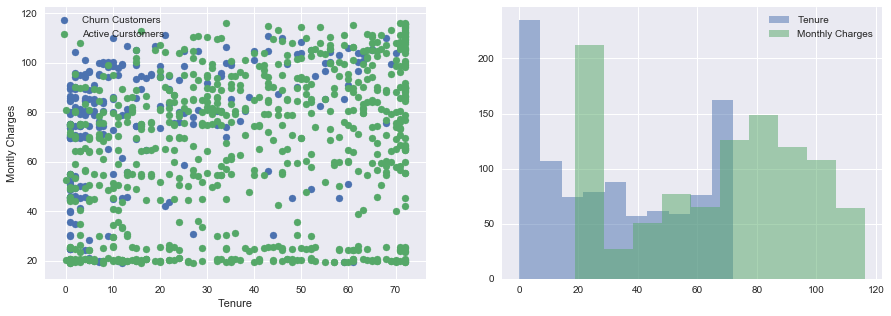

In [934]:
df = dfset.iloc[1:1000]
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(df.tenure[df.Churn == 'Yes'],df.MonthlyCharges[df.Churn == 'Yes'],label='Churn Customers')
axs[0].scatter(df.tenure[df.Churn == 'No'],df.MonthlyCharges[df.Churn == 'No'],label='Active Curstomers')
axs[0].set_xlabel('Tenure')
axs[0].set_ylabel('Montly Charges')

axs[0].legend(loc='best')
axs[1].hist((df.tenure),alpha=0.5,label='Tenure')
axs[1].hist(df.MonthlyCharges,alpha=0.5,label='Monthly Charges')
axs[1].legend(loc='best')
plt.show()

1.1 Quais os serviços mais contratados pelos clientes? Qual a diferença entre os serviços contrados pelos dois tipos de usuários (Churn e Active Customer)? Qual a influencia do gênero nesses dados?

C:\Users\Lira\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


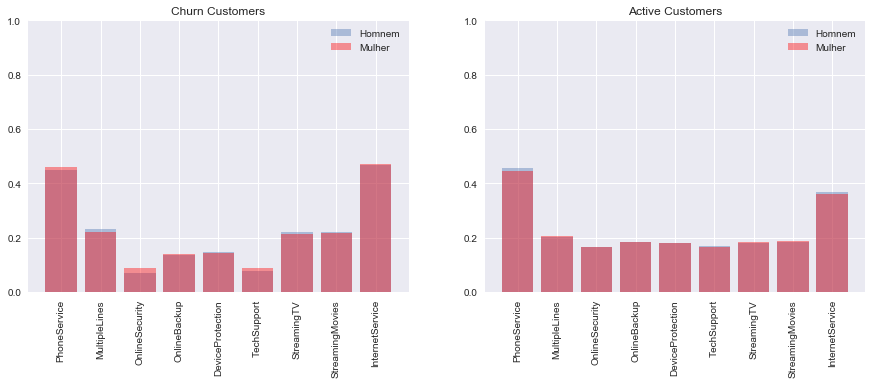

In [943]:
services = cat_cols[4:-3]

dfsets = [churnset[churnset['Churn'] == 'Yes'],churnset[churnset['Churn'] == 'No']]
fig,axs = plt.subplots(1,2,figsize=[15,5])

for i,dfset in enumerate(dfsets):
    services.remove('InternetService')
    norm = dfset.shape[0]
    mfreq_servs =  [dfset[dfset.gender=='Male' ][service].value_counts()['Yes']/norm for service in services]
    wfreq_servs =  [dfset[dfset.gender=='Female'][service].value_counts()['Yes']/norm for service in services]
    
    mfreq_servs.append(dfset[(dfset.gender=='Male') & (dfset.InternetService!='No')].shape[0]/norm)
    wfreq_servs.append(dfset[(dfset.gender=='Female') & (dfset.InternetService!='No')].shape[0]/norm)
    services.append('InternetService')

    axs[i].bar(range(1,len(mfreq_servs)+1),mfreq_servs,alpha = 0.4,tick_label=services,label='Homnem')
    axs[i].bar(range(1,len(wfreq_servs)+1),wfreq_servs,alpha = 0.4,color='r',label='Mulher')

    axs[i].set_xticklabels(services,rotation='vertical')    
    axs[i].legend(loc='best')
    
axs[0].set_title('Churn Customers')
axs[1].set_title('Active Customers')
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
fig.show()
    

Serviçoes de telefonia e internet são os mais contratados pelos clientes. Também não há distições no perfil de compra de acordo com o gênero. É interessante notar que os clientes ativos contratam mais serviços de de suporte e segurança, o que talvez possa trazer mais estabilidade e uma melhor experiência pelos usuários.

1.3 Qual o tempo médio que os usuários permanecem na empresa?

In [946]:
avr_tenure = churnset[churnset.Churn == 'Yes'].tenure.mean()
print('O número médio de meses que os usuários ficam na empresa é de: ',avr_tenure)

O número médio de meses que os usuários ficam na empresa é de:  17.979133226324237


### 2. Seleção de Features

2.1 Codificação das features categóricas

In [977]:
dfset['Churn'] = dfset['Churn'].astype('category').cat.codes
churn_df = pd.get_dummies(dfset,columns=cat_cols,drop_first=True)
print('Número de features após a codificação: ',churn_df.shape)
churn_df.columns

Número de features após a codificação:  (7043, 31)


Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male',
       'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

2.2 Aplicando PCA para redução de dimensionalidade:

PCA (Principal Component Analysis) é uma abordagem comumente utilizada para redução de dimensionalidade. Em altas dimensões, os modelos de predição tentem a ter overfiting se adquando muito aos dados de treino e não generalizando para novos dados. PCA consiste em fazer uma combinação linear dos vetores no espeço das features ($X$) a fim de encontrar novos vetores que melhor expliquem a variância dos dados. 
- Calcular a matriz de Gramm: $ S = X^TX $
- Fazer a decomposição em auto-valores e auto-vetores:  $U,S,V = SVD(S)$
- A variância explicada pelas $n$  principais componentes é dada por $\sum_{n}{tr(S_n)}$
- Aplicar a transformação linear $X' = V^TX$, onde $V$ é a matriz formação pelos $n$ primeiros vetores de $$


In [948]:
def split(ratio):
    msk = np.random.rand(len(churn_df))<ratio
    xtrain = churn_df[msk].drop(['TotalCharges','Churn'],axis=1)
    ytrain = churn_df[msk].Churn
    
    xtest = churn_df[~msk].drop(['TotalCharges','Churn'],axis=1)
    ytest = churn_df[~msk].Churn
    return xtrain,ytrain,xtest,ytest

Variância total explicada: 0.803482


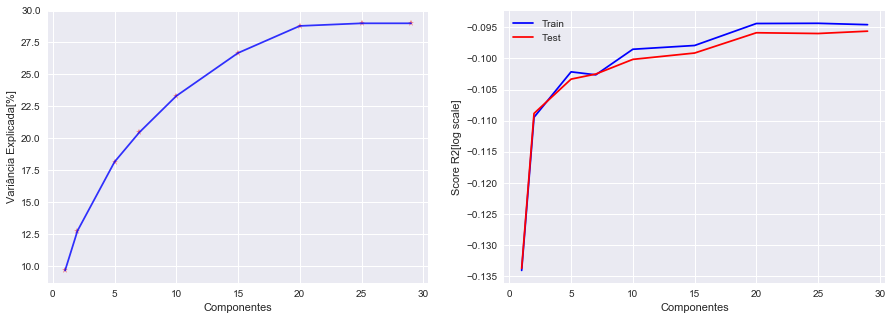

In [963]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# NOrmalização dos dados

xtrain,ytrain,xtest,ytest = split(0.7)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
X = xtrain_scaled

components = 10
U,S,V = np.linalg.svd(gramMtx)
gramMtx = X.T.dot(X)
S = S/np.sum(S)    
print("Variância total explicada: %f"%sum(S[:components]))

#Sklearn packege
explained_var = []
all_train_scores = []
all_test_scores = []
model = LogisticRegression(C=0.1)
comps = [1,2,5,7,10,15,20,25,29]

for i in comps:
    pca = PCA(n_components = i)    
    scores_train = []
    scores_test = []
    for j in range(100):
        xtrain,ytrain,xtest,ytest = split(0.7)
        scaler.fit(xtrain)
        xtrain_scaled = scaler.transform(xtrain)
        pca.fit(xtrain_scaled)
        xpca = pca.transform(xtrain_scaled)
        xtest_pca = pca.transform(scaler.transform(xtest))
                    
        clf = model.fit(xpca,ytrain)
        scores_train.append(clf.score(xpca,ytrain))
        scores_test.append(clf.score(xtest_pca,ytest))

    explained_var.append(np.sum(pca.explained_variance_))    
    all_train_scores.append(np.mean(scores_train))
    all_test_scores.append(np.mean(scores_test))
    
fig,axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(comps,explained_var,'r*',alpha=0.5)
axs[0].plot(comps,explained_var,'b-',alpha=0.8)
axs[0].grid(True)
axs[0].set_xlabel('Componentes')
axs[0].set_ylabel('Variância Explicada[%]')
axs[1].plot(comps,np.log10(all_train_scores),'b-',label='Train')
axs[1].plot(comps,np.log10(all_test_scores),'r-',label='Test')

#axs[1].set_ylim([0,1])

axs[1].grid(True)
axs[1].set_xlabel('Componentes')
axs[1].set_ylabel('Score R2[log scale]')
axs[1].legend(loc='best')


OBS: Embora as primeiras componentes não expliquem muito a variância dos dados, consegue-se bons valores nos scores de treino e teste levando em consideração apenas essas componentes no modelo.

Correlação entre dos dados após a tranformação

2.2 Analisando a correlação entre as features

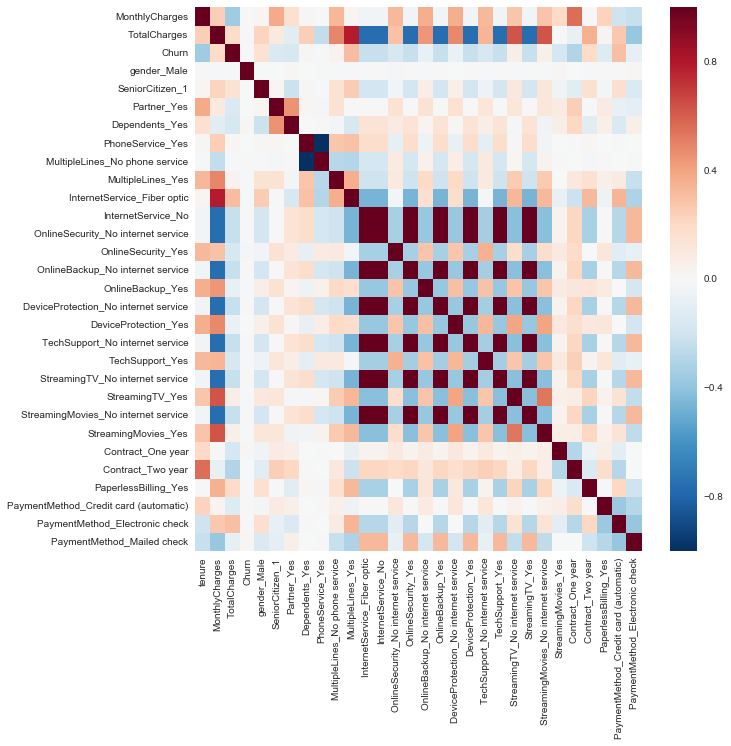

In [974]:
import seaborn as sns
columns = churn_df.columns
fig,ax = plt.subplots(1,1,figsize=[10,10])


sns.heatmap(churn_df.corr().values.T,ax=ax)
ax.set_xticklabels(columns,rotation='vertical')
ax.set_yticklabels(columns[::-1],rotation='horizontal')
plt.show()

### 3. Modelo Preditor: Logistic Regression
 Se representarmos as classes como um vetor $Y\in \{0,1\}$ e $X$ o vetor de features, desejamos calcular a seguinte probabilidade condicional:
 $$p(X) = Pr(Y = 1 | X)$$ onde 1 representa a classe Churn Customers e 0 Active Custorms. O vetor $Y$ pode ser modelado por uma regressão linear do tipo $Y= \beta_0 + \beta_1 X + e$, onde $\beta_0,\beta_1$ são os coeficientes da reta/hiperplano e $e$ o erro de aproximação, normalmente gaussiano. Normalizando o vetor de features, podemos interpretar $\hat{Y}$ como a probabilidade a prioride de $X$:
 
 $$ Pr(X) =  \hat{\beta_0} + \hat{\beta_1}X$$
 
 Para assegurar que $\hat{Y}$ esteja dentro do intervalo $[0,1]$, aplica-se uma funçao de suavização. No caso da Regressão logística, utiliza-se a função logit:
     $$ p(X) =  \frac{\exp{(\hat{Y})}}{1+\exp{(\hat{Y})}} = \frac{\exp{(\hat{\beta_0} + \hat{\beta_1})}}{1+\exp{(\hat{\beta_0} + \hat{\beta_1})}} $$

A estimação dos parâmetros $\beta_0,\beta_1$ poder ser feita pelo método dos mínimos quadrados não-linear que minimiza o erro médio quadrático (MSE), ou através do estimador de máxima verossimilhança. Uma vez estimado os parâmetros usando os dados de treino, pode-se predizer novas classes simplesmentes calculando a probabilidade $p(X)$. Se este valor for alto, próximo de 1, maior a probabilidade de o cliente mudar de companhia. O complemente de $p(X)$ nos dá a probabilidade de o cliente continuar comprando os serviços da empresa.
 

In [989]:
from sklearn.metrics import classification_report
import statsmodels.api as sm


xtrain,ytrain,xtest,ytest = split(0.7)
model = LogisticRegression(C=0.1)
clf = model.fit(xtrain.values,ytrain.values)
pred = clf.predict(xtest)


score_all = clf.score(xtest,ytest)
confusion = confusion_matrix(ytest,pred)
report = classification_report(ytest,pred)

### Matriz de confusão
Para comparar os classificadores normalmente se analisa a taxa de acerto em cada classe do conjunto de teste. No nosso caso con Temos os seguintes casos:
- Quando o cliente é da classe positiva e o classificador prediz a classe positiva - Verdadeiro Positivo (TP)
- Quanto o cliente é da classe negativa e o classicador prediz erroneamente a classe positiva - Falso Positivo (FP)
- Quanto o cliente é da classe negativa e o classificador prediz a classe negativa - Verdadeiro Negativo (TN)
- E finalmente o caso em que o cliente é da classe positiva mas é classificado como sendo da negativa - Falso Negativo (FN)

Apartir destes valores construímos a matriz de confusão:
![hwimages](./confusionmatrix.png)

In [990]:
print('Score de teste considerando todas as features: ',score_all)
print('')
print('Matriz de confusão:')
print(confusion)

Score de teste considerando todas as features:  0.805309734513

Matriz de confusão:
[[1355  132]
 [ 264  283]]


In [991]:
pca = PCA(n_components = 7)
pca.fit(scaler.transform(xtrain),ytrain)
xpca = pca.transform(scaler.transform(xtrain))
xtest_pca = pca.transform(scaler.transform(xtest))

clf = model.fit(xpca,ytrain)
pred = clf.predict(xtest_pca)
score_pca = clf.score(xtest_pca,ytest.values)

confusion = confusion_matrix(ytest,pred)
report = classification_report(ytest,pred)

print('Score de teste considerando as 7 principais componentes: ',score_pca)
print('')
print('Confusion Matrix:')
print(confusion)

Score de teste considerando as 7 principais componentes:  0.784169124877

Confusion Matrix:
[[1351  136]
 [ 303  244]]



OBS: Obteve-se uma redução de mais de 80% no número de features, mesmo considerando o número original de 20 feat, é uma redução considerável. E mais importante, manteve-se o valor do score de teste quase inalterado.

#### Sumarização dos coeficientes:

In [984]:
lm = sm.Logit(ytrain.values,sm.add_constant(xpca)).fit()
lm.summary()

Optimization terminated successfully.
         Current function value: 0.430500
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4935
Model:                          Logit   Df Residuals:                     4927
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Dec 2017   Pseudo R-squ.:                  0.2490
Time:                        14:10:25   Log-Likelihood:                -2124.5
converged:                       True   LL-Null:                       -2829.0
                                        LLR p-value:                4.534e-300
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5054      0.048    -31.683      0.000      -1.599      -1.412
x1            -0.2141      0.018    -12.058      0.000      -0.249      -0.179
x2            -0.6965      0.028    -24.806      0.000      -0.752      -0.641
x3            -0.2751      0.024    -11.381      0.000      -0.322      -0.228
x4             0.1986      0.031      6.314      0.000       0.137       0.260
x5            -0.0097      0.042     -0.233      0.816      -0.092       0.072
x6            -0.0989      0.038     -2.622      0.009      -0.173      -0.025
x7             0.0123      0.039      0.314      0.753      -0.064       0.089
==============================================================================
"""

Prever quais usuários tem propensão de deixar a empresa pode levar ações corretivas que evitem essa perda para empresa. 
Utilizando-se o modelo acima, a seguir calcula-se a perda mensal que pode ser evitada.

In [985]:
lossCharge = sum(xtest[pred == ytest].MonthlyCharges)
print('Total Monthly Charges: ',lossCharge)

Total Monthly Charges:  100882.95


In [986]:
ids=np.argsort(np.abs(pca.components_[1,:]))#np.argmax(np.abs(pca.components_[1,:]))
xtrain.columns[ids]

Index(['gender_Male', 'InternetService_Fiber optic',
       'PaymentMethod_Mailed check', 'PaperlessBilling_Yes', 'SeniorCitizen_1',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'TechSupport_No internet service', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'StreamingMovies_No internet service',
       'DeviceProtection_No internet service',
       'StreamingTV_No internet service', 'Contract_One year',
       'MonthlyCharges', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'MultipleLines_Yes', 'OnlineBackup_Yes',
       'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_Yes',
       'Dependents_Yes', 'DeviceProtection_Yes',
       'PaymentMethod_Electronic check', 'TechSupport_Yes', 'Partner_Yes',
       'Contract_Two year', 'tenure'],
      dtype='object')

array([27, 29, 34, 39, 41, 47, 38, 40, 42, 43, 44, 48, 45, 55, 46, 28, 32,
       36, 31, 37, 35, 59,  1, 53, 51, 23, 50, 33, 21, 58, 61, 25, 26, 30,
       63, 57, 16, 24, 54, 20, 56, 64, 60, 18, 49, 52, 22, 17, 62, 19, 67,
       12, 15, 10, 65, 14, 77, 78, 70,  9, 66, 69, 99, 13, 72, 11, 73, 68,
       94,  8, 92, 90, 88, 86, 84, 82, 81, 71,  0,  2, 80, 96,  7, 74,  6,
       75, 93, 91, 79, 85,  5, 97,  4, 83, 87, 89, 98, 76,  3, 95], dtype=int64)